# Analysis for objective function 5: base line regret

This notebook contains the analyses for the fifth objective function: 90th percentile regret

$$
\begin{equation}
    \begin{aligned}
    & \text{Minimize} && F(l_{p,r}) = (f_{damages}, f_{casualties}, f_{costs}) \\
    & \text{where} && l_{p,r} = [p_1,p_2,p_3, r_1,r_2]  &&&\forall p \in P; \forall r \in R\\
    & &&f_i = \max_i \{D_{i,90}:P[D_i\leq D_{i,90}]=90\} &&& i \in \{damages, casualties, costs\} \\
    & && D_{i,n} = \frac{|F(x)_{i,n} - F(x)_i^* |}{F(x)_i^*}
    \end{aligned}
\end{equation}
$$

where $F(x)_i^*$ presents the performance on objective $i$ in the base line state of the world. $F(x)_{i,n}$ is the performance on objective $i$ in state of the world $n$


In [1]:
from __future__ import division

import scipy as sp
import seaborn as sns

from expWorkbench import load_results, ema_logging

sns.set_style('whitegrid')
ema_logging.log_to_stderr(ema_logging.INFO);

In [2]:

results = load_results(r'./data/25 pathways 200 experiments.tar.gz')

[INFO/MainProcess] results loaded succesfully from ./data/25 pathways 200 experiments.tar.gz


In [3]:
from expWorkbench import save_results
experiments, outcomes = results

logical = experiments['policy']=='None'
temp_experiments = experiments[logical]
temp_outcomes = {key:value[logical] for key, value in outcomes.items()}

temp_results = temp_experiments, temp_outcomes
save_results(temp_results, r'./data/base_case.tar.gz')

[INFO/MainProcess] results saved successfully to ./data/base_case.tar.gz


In [4]:
from __future__ import division
import copy
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker  

def _group_outcomes_by_policy(experiments, outcomes, policy_labels):
    '''Helper function for grouping results by policy and sort them in 
    the same order using the specified uncertainty
    
    Parameters
    ----------
    experiments : recarray
    outcomes : dict 
    policy_labels : list of strings
    
    Returns:
    --------
    dict
        outcomes grouped by policy and sorted by uncertainty_to_sort_by
    '''


    # group outcomes by policy and sort based on the selected
    # uncertainty
    outcomes_by_policy = {}
    for policy_label in policy_labels:
        logical = experiments['policy'] == policy_label
        
        policy_experiments = experiments[logical]
        
        policy_outcomes = {key: value[logical] for key, value in 
                           outcomes.iteritems()}
        
        outcomes_by_policy[policy_label] = policy_outcomes
    return outcomes_by_policy


def _calculate_regret_base_case(policy_outcomes, outcomes_by_policy):
    '''helper function calculating regret by comparing
    it to the base case
    
    Parameters
    ----------
    outcomes_policy : dict
    outcomes_other : dict
    
    Returns
    -------
    dict
    
    '''
    try:
        no_policy = outcomes_by_policy.pop('None')
    except KeyError:
        return {key:0 for key in policy_outcomes.keys()}

    regret = {}
    for key, value in policy_outcomes.items():
        no_policy_value = no_policy[key]
        if key=='Costs':
            no_policy_value[:] = 1
            value = value+1 
        
        regret_distribution = (value - no_policy_value) / no_policy_value
        regret[key] = np.percentile(regret_distribution, 90)
    return regret


def _calculate_regret_best_case(policy_outcomes, outcomes_by_policy):
    '''helper function calculating regret by comparing
    it to the base case
    
    Parameters
    ----------
    outcomes_policy : dict
    outcomes_other : dict
    
    Returns
    -------
    dict
    
    '''

    best = {key:value for key, value in policy_outcomes.items()}
    for values in outcomes_by_policy.values():
        for key, best_value in best.items():
            best[key] = np.minimum(best_value, values[key]) 

    regret = {}
    for key, value in policy_outcomes.items():
        best_value = best[key]
        
        regret_distribution = (value - best_value) / value
        regret[key] = np.percentile(regret_distribution, 90)
    return regret

def _calculate_regret_for_policy(population, 
                                 policy,
                                 outcomes_by_policy,
                                 regret_func=_calculate_regret_base_case):
    '''Helper function for calculating regret of a given policy versus
    all other policies
    
    Parameters
    ----------
    population : list
        list of Individuals as generated through the deap library
    policy : dict
        the policy for which regret is being calculated
    outcomes_by_policy : dict
        return of _group_outcomes_by_policy
    regret_func : function
        function that calculates regret
        
    Returns
    -------
    dict
        regret for each outcome
    
    '''
    
    regret = {}
    policy_name = policy['name']
    
    outcomes_by_policy = copy.deepcopy(outcomes_by_policy)
    
    policy_outcomes = outcomes_by_policy.pop(policy_name)

    regret = regret_func(policy_outcomes, outcomes_by_policy)
    
     
    return regret


def dominates(a, b):
    """Return true if each objective of *a* is not strictly worse than 
    the corresponding objective of *b* and at least one objective is 
    strictly better.

    """
    not_equal = False
    for ai, bi in zip(a, b):
        if ai < bi:
            not_equal = True
        elif ai > bi:
            return False                
    return not_equal


def sort_nondominated(individuals):
    """Sort the *individuals* into different nondomination levels 
    using the "Fast Nondominated Sorting Approach" proposed by Deb et al.,
    see [Deb2002]_. 
    
    :param individuals: A dataframe of individuals to select from.
    :returns: A list of Pareto fronts (lists), the first list includes 
              nondominated individuals.

    adapted from implementation available in deap
    """
    map_fit_ind = defaultdict(list)
    for i in range(individuals.shape[0]):
        values = tuple(individuals.ix[i].values)
        map_fit_ind[values].append(i)
    fits = map_fit_ind.keys()
    
    current_front = []
    next_front = []
    dominating_fits = defaultdict(int)
    dominated_fits = defaultdict(list)
    
    # Rank first Pareto front
    for i, fit_i in enumerate(fits):
        for fit_j in fits[i+1:]:
            if dominates(fit_i, fit_j):
                dominating_fits[fit_j] += 1
                dominated_fits[fit_i].append(fit_j)
            elif dominates(fit_j, fit_i):
                dominating_fits[fit_i] += 1
                dominated_fits[fit_j].append(fit_i)
        if dominating_fits[fit_i] == 0:
            current_front.append(fit_i)
    
    fronts = [[]]
    for fit in current_front:
        fronts[-1].extend(map_fit_ind[fit])
    pareto_sorted = len(fronts[-1])

    # Rank the next front until all individuals are sorted or 
    # the given number of individual are sorted.
    N = len(individuals)
    while pareto_sorted < N:
        fronts.append([])
        for fit_p in current_front:
            for fit_d in dominated_fits[fit_p]:
                dominating_fits[fit_d] -= 1
                if dominating_fits[fit_d] == 0:
                    next_front.append(fit_d)
                    pareto_sorted += len(map_fit_ind[fit_d])
                    fronts[-1].extend(map_fit_ind[fit_d])
        current_front = next_front
        next_front = []
    
    return fronts


def make_parallel_plot(nr_columns, labels, maxima, minima):

    fig = plt.figure()
    axes = []
    
    # we need one axes less than the shape
    for i in range(1, nr_columns):
        ax = fig.add_subplot(1,nr_columns-1,i,  ylim=(-0.1,1.1))
        axes.append(ax)
        ax.set_xlim([i,i+1])
        ax.xaxis.set_major_locator(ticker.FixedLocator([i]))
        ax.xaxis.set_ticklabels([labels[i-1]], rotation=45)
        ax.xaxis.set_tick_params(bottom=False, top=False)
        
        #let's put our own tick labels
        ax.yaxis.set_ticks([])
        ax.text(i, 1.01, "{:.2f}".format(maxima[i-1]), va="bottom", ha="center")
        ax.text(i, -0.01,"{:.2f}".format(minima[i-1]), va="top", ha="center")
        
        ax.spines['left'].set_bounds(0, 1)
        ax.spines['right'].set_bounds(0, 1)
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)

    
    # for the last axis, we need 2 ticks (also for the right hand side
    ax.spines['right'].set_bounds(0, 1)
    ax.xaxis.set_major_locator(ticker.FixedLocator([i, i+1]))
    ax.xaxis.set_ticklabels(labels[i-1:i+1])
    ax.text(i+1, 1.01, "{:.2f}".format(maxima[i]), va="bottom", ha="center")
    ax.text(i+1, -0.01,"{:.2f}".format(minima[i]), va="top", ha="center")
    
    # add the tick labels to the rightmost spine
    for tick in ax.yaxis.get_major_ticks():
        tick.label2On=True
    
    # stack the subplots together
    plt.subplots_adjust(wspace=0)
    
    return axes


def normalize(data):
    minima = np.min(data, axis=0)
    maxima = np.max(data, axis=0)
    d = maxima - minima

    d[d==0] = 1

    norm_data = data/d - minima/d
    return norm_data, minima, maxima

# regret compared to base case

In [5]:
experiments, outcomes = results

policy_labels = list(set(experiments['policy']))
outcomes_by_policy = _group_outcomes_by_policy(experiments, outcomes, policy_labels)

population = [{'name':entry,
               'a':i} for i, entry in enumerate(policy_labels)]

regret = {}
for entry in population:
    policy_name = entry.get('name')
    policy_regret = _calculate_regret_for_policy(population, 
                                                 entry, 
                                                 outcomes_by_policy)
    regret[policy_name] = policy_regret

In [6]:
regret = pd.DataFrame(regret).T
regret

,Costs,Flood damage (Milj. Euro),Number of casualties
None,0.000000,0.000000,0.000000
obj_1_0,232.093167,-0.942896,-0.614411
obj_1_1,174.722060,-0.973593,-0.716177
obj_1_2,6.210000,-0.670803,0.000000
obj_1_3,125.120000,-0.340077,-0.236002
obj_1_4,50.060000,-0.167400,-0.035834
obj_1_5,0.090000,0.000000,-0.059919
obj_2_0,174.722060,-0.973593,-0.716177
obj_2_1,194.134583,-0.805093,-0.516517
obj_2_2,174.752060,-0.782823,-0.395555


In [7]:
fronts = sort_nondominated(regret)
fronts

[[3, 19, 24, 6, 16, 25, 0, 2, 7, 5],
 [11, 22, 4, 12, 17, 9, 15, 21],
 [14, 13, 1, 18],
 [20, 10, 23, 8]]

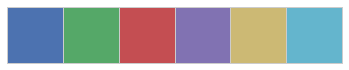

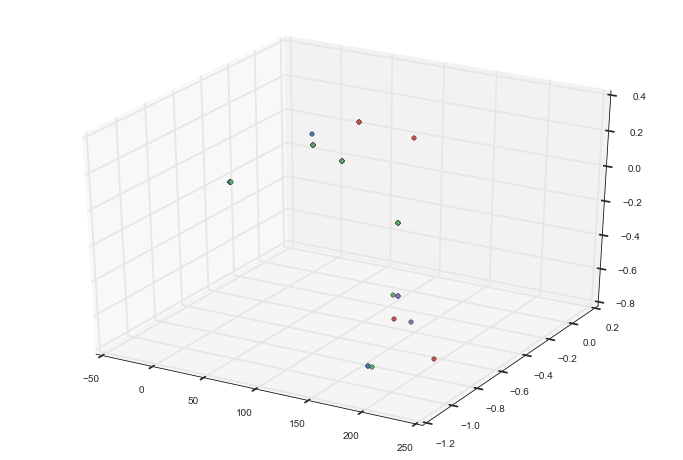

In [8]:
from mpl_toolkits.mplot3d import Axes3D

current_palette = sns.color_palette()
sns.palplot(current_palette)

data = regret.values
x = data[:,0]
y = data[:,1]
z = data[:,2]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i, front in enumerate(fronts):
    ax.scatter(x[front],y[front],z[front], c=current_palette[i], depthshade=False)
plt.show()

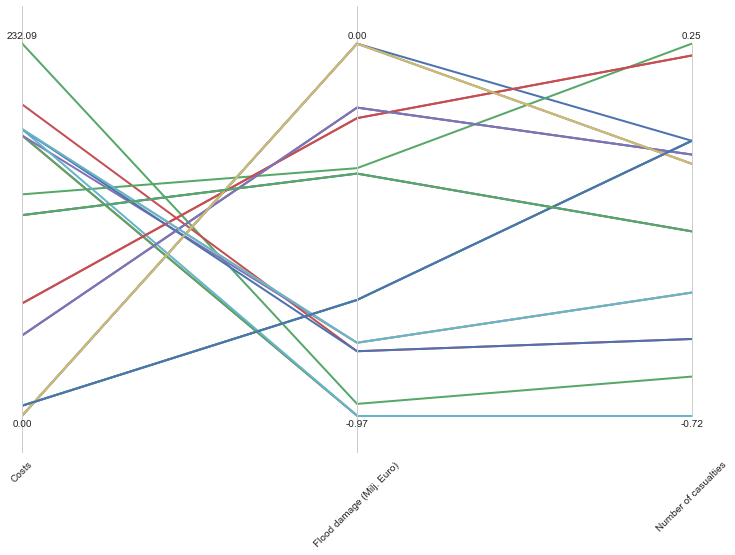

In [9]:
values = regret.values
values, minima, maxima = normalize(values)
labels = regret.columns
axes = make_parallel_plot(3, labels, maxima, minima)

for i,j in zip(range(values.shape[1]-1),range(1,values.shape[1])):
    ax = axes[i]
    y = values[:, i:j+1]
    x = np.tile([i+1,j+1], (values.shape[0], 1))
    ax.plot(x.T, y.T, lw=2)

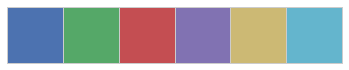

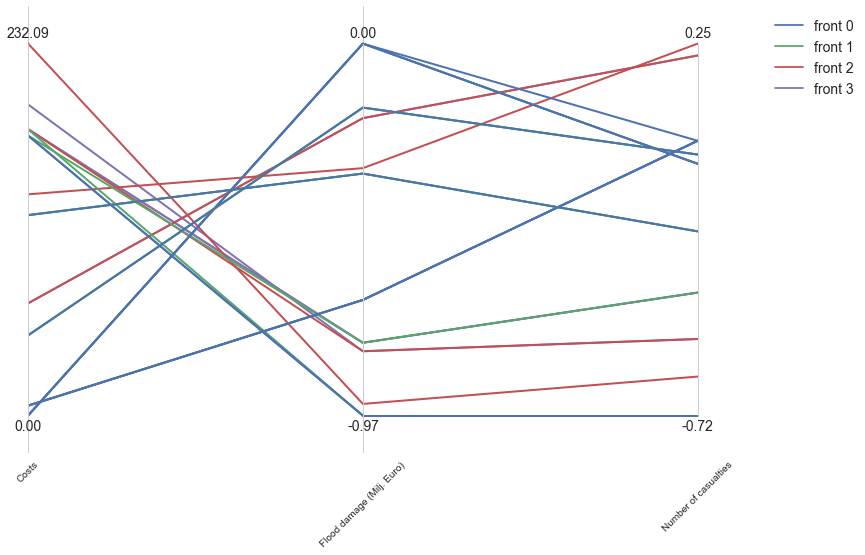

In [10]:
# sns.set_style?
with sns.axes_style({"font.size":14.0}) as style:
    current_palette = sns.color_palette()
    sns.palplot(current_palette)

    values = regret.values
    values, minima, maxima = normalize(values)

    labels = regret.columns
    axes = make_parallel_plot(3, labels, maxima, minima)

    a = fronts[::-1]

    legend_items = []
    for c, front in enumerate(a):
        data = values[front]

        for i,j in zip(range(data.shape[1]-1),range(1,data.shape[1])):
            ax = axes[i]
            y = data[:, i:j+1]
            x = np.tile([i+1,j+1], (data.shape[0], 1))
            color = current_palette[len(fronts)-c-1]
            lines = ax.plot(x.T, y.T, lw=2,  
                            c=color,
                            label=c)
        legend_items.append(mpl.lines.Line2D([0,1], [0,1], color=color))


    ax.legend(legend_items[::-1], ['front {}'.format(i) for i in range(4)], 
              borderaxespad=0.5, bbox_to_anchor=(1.4, 1, .102, 0), fontsize=14)
plt.show()

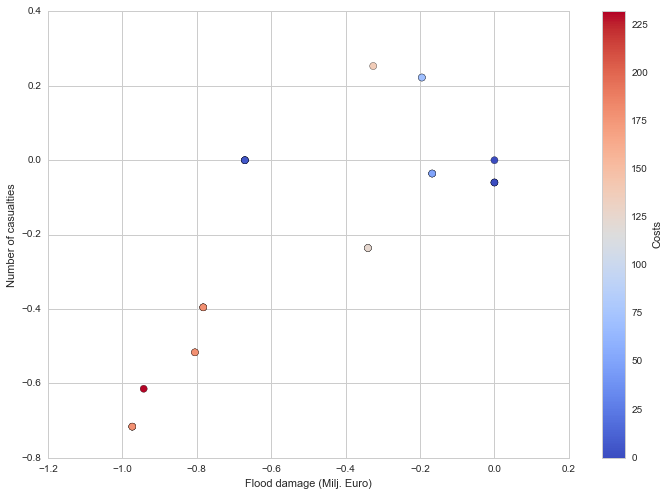

In [11]:
values = regret.values.T

x = values[1,:]
y = values[2,:]
z = values[0,:]

fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')
c = ax.scatter(x,y,c=z, cmap=mpl.cm.coolwarm, s=50)
cbar = fig.colorbar(c,ax=ax)
ax.set_xlabel(regret.columns[1])
ax.set_ylabel(regret.columns[2])
cbar.set_label(regret.columns[0])
plt.show()



# Analysis for objective function 6: regret compared to best

This notebook contains the analyses for the fifth objective function: 90th percentile regret

$$
\begin{equation}
    \begin{aligned}
    & \text{Minimize} && F(l_{p,r}) = (f_{damages}, f_{casualties}, f_{costs}) \\
    & \text{where} && f_i = \max_i \{D_{i,90}:P[D_i\leq D_{i,90}]=90\} &&& i \in \{damages, casualties, costs\} \\
    & && D_{i,j} = |F(x)_{i,j} - min_s F(x_s)_{i,j} |
    \end{aligned}
\end{equation}
$$

where $min_s F(x_s)_{i,j}$ presents the best performance on objective $i$ across all states of the world. $F(x)_{i,j}$ is the performance on objective $i$ in state of the world $j$



In [12]:
from __future__ import division

def _calculate_regret_best_case(policy_outcomes, outcomes_by_policy):
    '''helper function calculating regret by comparing
    it to the base case
    
    Parameters
    ----------
    outcomes_policy : dict
    outcomes_other : dict
    
    Returns
    -------
    dict
    
    '''

    best = {key:value for key, value in policy_outcomes.items()}
    for values in outcomes_by_policy.values():
        for key, best_value in best.items():
            best[key] = np.minimum(best_value, values[key]) 

    regret = {}
    for key, value in policy_outcomes.items():
        best_value = best[key]
    
        regret_distribution = (value - best_value)
        
        regret[key] = np.percentile(regret_distribution, 90)
    return regret
        
experiments, outcomes = results

policy_labels = list(set(experiments['policy']))
outcomes_by_policy = _group_outcomes_by_policy(experiments, outcomes, policy_labels)

population = [{'name':entry,
               'a':i} for i, entry in enumerate(policy_labels)]

regret = {}
for entry in population:
    policy_name = entry.get('name')
    policy_regret = _calculate_regret_for_policy(population, 
                                                 entry, 
                                                 outcomes_by_policy,
                                                 regret_func=_calculate_regret_best_case)
    regret[policy_name] = policy_regret

In [13]:
regret = pd.DataFrame(regret).T
regret

,Costs,Flood damage (Milj. Euro),Number of casualties
None,0.000000,59618.1,1250.541660
obj_1_0,232.093167,1278.3,102.712000
obj_1_1,174.722060,420.2,67.395480
obj_1_2,6.210000,13895.1,1250.541660
obj_1_3,125.120000,33162.2,367.834596
obj_1_4,50.060000,46142.3,843.496800
obj_1_5,0.090000,59618.1,736.684770
obj_2_0,174.722060,420.2,67.395480
obj_2_1,194.134583,6580.0,208.863510
obj_2_2,174.752060,7308.8,253.591430


In [14]:
fronts = sort_nondominated(regret)
fronts

[[0, 14, 3, 19, 24, 5, 6, 16, 25, 2, 7],
 [20, 11, 15, 21, 22, 4, 12, 9, 17],
 [13, 18, 1],
 [10, 23, 8]]

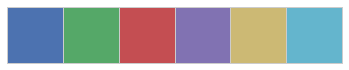

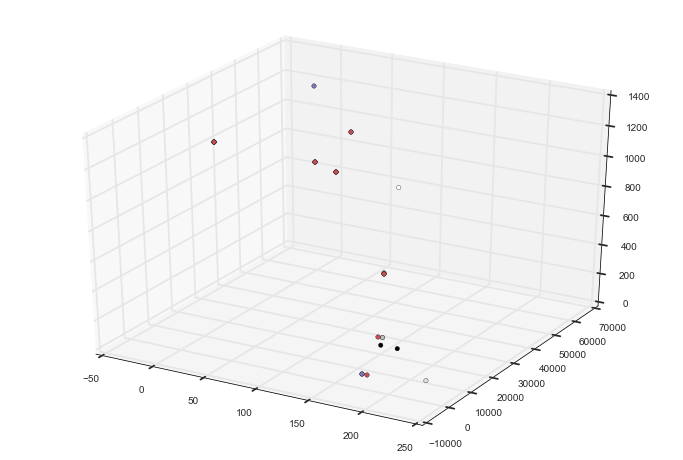

In [15]:


current_palette = sns.color_palette()
sns.palplot(current_palette)

data = regret.values
x = data[:,0]
y = data[:,1]
z = data[:,2]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

temp_fronts = fronts[::-1]
for i, front in enumerate(temp_fronts):
    ax.scatter(x[front],y[front],z[front],
               c=current_palette[i], 
               depthshade=False)
plt.show()

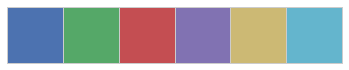

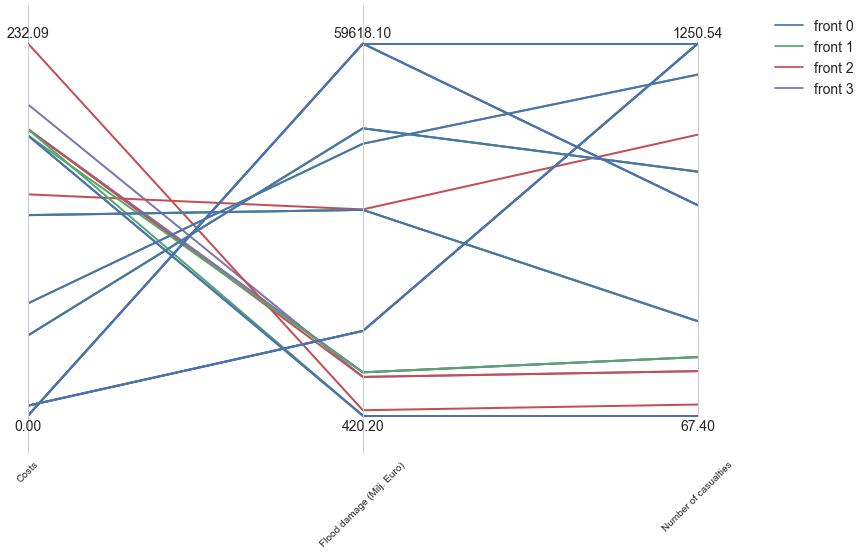

In [16]:
# sns.set_style?
with sns.axes_style({"font.size":14.0}) as style:
    current_palette = sns.color_palette()
    sns.palplot(current_palette)

    values = regret.values
    values, minima, maxima = normalize(values)

    labels = regret.columns
    axes = make_parallel_plot(3, labels, maxima, minima)

    a = fronts[::-1]

    legend_items = []
    for c, front in enumerate(a):
        data = values[front]

        for i,j in zip(range(data.shape[1]-1),range(1,data.shape[1])):
            ax = axes[i]
            y = data[:, i:j+1]
            x = np.tile([i+1,j+1], (data.shape[0], 1))
            color = current_palette[len(fronts)-c-1]
            lines = ax.plot(x.T, y.T, lw=2,  
                            c=color,
                            label=c)
        legend_items.append(mpl.lines.Line2D([0,1], [0,1], color=color))


    ax.legend(legend_items[::-1], ['front {}'.format(i) for i in range(4)], 
              borderaxespad=0.5, bbox_to_anchor=(1.4, 1, .102, 0), fontsize=14)
plt.show()

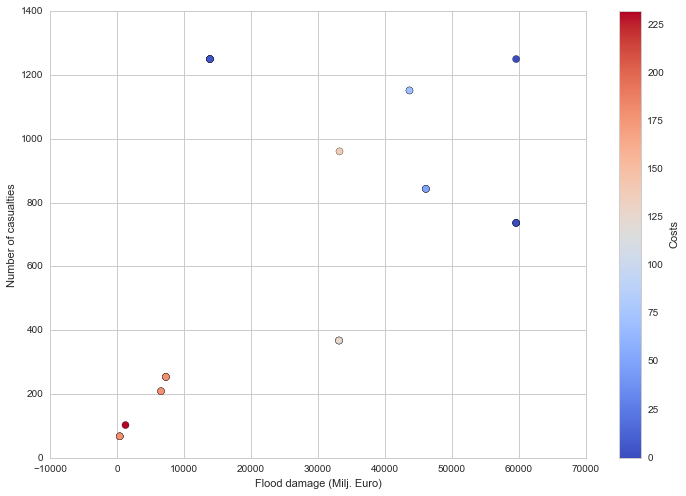

In [17]:
values = regret.values.T

x = values[1,:]
y = values[2,:]
z = values[0,:]

fig = plt.figure()
ax = fig.add_subplot(111)
c = ax.scatter(x,y,c=z, cmap=mpl.cm.coolwarm, s=50)
cbar = fig.colorbar(c,ax=ax)
ax.set_xlabel(regret.columns[1])
ax.set_ylabel(regret.columns[2])
cbar.set_label(regret.columns[0])
plt.show()


# comparison

In [18]:
a = [[0, 14, 3, 19, 24, 5, 6, 16, 25, 2, 7],
     [20, 11, 15, 21, 22, 4, 12, 9, 17],
     [13, 18, 1],
     [10, 23, 8]]

b = [[3, 19, 24, 6, 16, 25, 0, 2, 7, 5],
     [11, 22, 4, 12, 17, 9, 15, 21],
     [14, 13, 1, 18],
     [20, 10, 23, 8]]

a = [sorted(entry) for entry in a]
b = [sorted(entry) for entry in b]

In [19]:
a

[[0, 2, 3, 5, 6, 7, 14, 16, 19, 24, 25],
 [4, 9, 11, 12, 15, 17, 20, 21, 22],
 [1, 13, 18],
 [8, 10, 23]]

In [20]:
b

[[0, 2, 3, 5, 6, 7, 16, 19, 24, 25],
 [4, 9, 11, 12, 15, 17, 21, 22],
 [1, 13, 14, 18],
 [8, 10, 20, 23]]

* in the pareto front, 14 is only present in base case regret
* in the second front 20 is only present in best case regret


In [21]:
import json

with open(r'./data/pathways.json') as fh:
    pathways = json.load(fh)
    
names = []
for pathway in pathways:
    elements = [pathway["action_{}".format(i)]['name'] for i in range(1,4)]
    name = "{}; {}; {}".format(*elements)
    names.append(name)
names.insert(0, 'None')

In [25]:
for entry in a[0]:
    print names[entry]

None
Dike 1:500 extr.; Alarm Early; Alarm Late
DC Floating; Alarm Early; Coop Small
RfR Side channel; Alarm Early; Alarm Late
Alarm Early; Alarm Early; Alarm Late
Dike 1:500 extr.; Coop Small; Alarm Early
RfR Small Scale; Coop Small; Alarm Early
Alarm Early; Alarm Early; Alarm Early
DC Floating; Alarm Late; Alarm Early
DC Floating; Alarm Early; Alarm Education
Dike Wave resistant; Alarm Early; Alarm Education


In [26]:
for entry in b[0]:
    print names[entry]

None
Dike 1:500 extr.; Alarm Early; Alarm Late
DC Floating; Alarm Early; Coop Small
RfR Side channel; Alarm Early; Alarm Late
Alarm Early; Alarm Early; Alarm Late
Dike 1:500 extr.; Coop Small; Alarm Early
Alarm Early; Alarm Early; Alarm Early
DC Floating; Alarm Late; Alarm Early
DC Floating; Alarm Early; Alarm Education
Dike Wave resistant; Alarm Early; Alarm Education


In [23]:
print names[14]
print names[20]

RfR Small Scale; Coop Small; Alarm Early
RfR Small Scale; Alarm Early; Coop Medium


In [24]:
for entry in b[-1]:
    print names[entry]

Dike 1:1000; Dike 1:500 extr.; RfR Side channel
Dike 1:500 +0.5m; Alarm Early; Dike 1:1000
RfR Small Scale; Alarm Early; Coop Medium
Dike 1:500 +0.5m; Alarm Early; Coop Small
